# When and where do fires start ?

The aim of this code is to take as an input the daily fire risk maps and to create a list of dates and lon / lat where ignitions occurs. 

#### 1. Scaling part:
- Calculate number of yearly historical fires and yearly sum of probabilities above a threshold (from ML model). 
- Linear regression of the ML yearly sum to the yearly historical fires

--> output: slope + intercept

#### 2. Apply scaling to fire risk probabilities to obtain daily number of fires (When fires happen?):
- Obtain the yearly expected number of fires by applying scaling to ML fire risk probabilities
- For each year define a factor as expected number of fires / sum of probability above threshold and scale the daily probabilities

--> output: for each day, the number of fires starting across Europe 

#### 3. Select location of fires (Where fires happen?)
- Loop through each day and select location of fire based on either a threshold value of the dice method (see code for more info)

--> output: List of dates with corresponding lon / lat

#### 4. Visualise and compare results to observation
- Calculate number of fires generated for each 10x10km grid cell
- Compare the range of ids / locations

The list is then used to run ForeFire. 

In [75]:
import geopandas as gpd
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats

In [76]:
folder = 'ML-data-Europe-gridded'
save = False

In [77]:
if folder == 'ML-data-Europe-gridded':
    historic_file = 'EFFIS_Burned_Areas_2008-2023_grided.shp'
else:
    historic_file = 'EFFIS_Burned_Areas_2008-2023_greater10ha_grided.shp'

In [78]:
path = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder  + "/"

### 1. Scaling part

#### Load datasets: ML probabilities

In [79]:
# Fire probability
df_probs = pd.read_csv(path + 'results/all-predictors/daily_probas_2008-2023_fire-season.csv') #path + 'results/all-predictors/daily_probas_2008-2023_fire-season.csv')

In [80]:
df_probs = df_probs.set_index(np.int64(df_probs.id))

In [81]:
df_probs = df_probs.iloc[:, 1:]

In [82]:
# Update column names to date times 
dates = pd.date_range('2008-01-01', '2023-12-31', freq = 'D')

# Only fire season so months outside fire season are filtered out 
for m in [1, 2, 3, 4, 5, 11, 12]:
    dates = dates[ ~(dates.month == m)]

df_probs = df_probs.set_axis(dates, axis=1)

#### Load datasets: Historical record of fires

In [83]:
# Historical fires
fires_all = gpd.read_file(path + 'historical_ignition/' + historic_file ) #path + 'historical_ignition/EFFIS_Burned_Areas_bigger50ha_grided_2008-2023.shp')

In [84]:
fires_all['date'] = pd.to_datetime(fires_all['initialdat'], infer_datetime_format=True)

C:\Users\ophme\AppData\Local\Temp\ipykernel_49588\3498558202.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fires_all['date'] = pd.to_datetime(fires_all['initialdat'], infer_datetime_format=True)


In [85]:
# Remove hours / seconds from date
fire_dates = []
for i, row in fires_all.iterrows():
    fire_dates.append(str(row.date)[:10])

fires_all['date'] = pd.to_datetime(fire_dates)

In [86]:
# Filter out fires outside fire season:
for m in [1, 2, 3, 4, 5, 11, 12]:
    fires_all = fires_all[~(fires_all.date.dt.month == m )] 


#### Calculate number of fires for historical period and using a threshold

In [87]:
years = np.arange(2008, 2024, 1)
prob = 0.7 # select threshold value

In [88]:
combined_fires = np.zeros(153)
combined_fires_ml = np.zeros(153)

combined_fires_yearly = np.zeros((len(years), 153))
combined_fires_yearly_ml = np.zeros((len(years), 153))

yearly_sum = []
yearly_sum_ml = []

for y, year in enumerate(years): 

    year = str(year)
    
    ### 1. Historical fires 
    
    # Select only the fires from a given year 
    fires = fires_all[(fires_all.date.dt.year == int(year) )] 

    # Select only dates for a given year
    dates_year = dates[dates.year == int(year)]
       
    number_fires = np.zeros(len(dates_year))

    # For each day count the number of fires in the historical record 
    for i, day in enumerate(dates_year):
        number_fires[i] = sum(fires.date == str(day)[:10])
        
    yearly_sum.append(len(fires))
    combined_fires = combined_fires + number_fires
    combined_fires_yearly[y, :] = number_fires

    ### 2. ML fires 
    
    # Select only the probabilities from a given year 
    df = df_probs.filter(like= year)
    
    prob_filter = np.zeros(len(dates_year))
    
    k = 0
    for column_name, item in df.items():
        vals = np.zeros(len(item))
        vals[item > np.ones(len(vals)) * prob] = 1
        prob_filter[k] = np.sum(vals)       
        k = k+1
        
    combined_fires_ml = combined_fires_ml + prob_filter
    yearly_sum_ml.append(np.nansum(prob_filter))
    combined_fires_yearly_ml[y, :] = prob_filter
   

#### Compare number of fires

Text(0.5, 1.0, 'Yearly sum of fires in S. Europe')

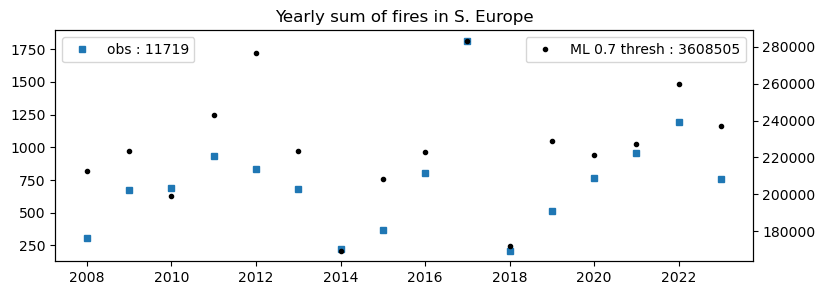

In [89]:
fig, ax = plt.subplots(figsize = (9, 3))
ax2 = ax.twinx()
ax.plot(years, yearly_sum, 's', label = 'obs : ' + str(int(np.nansum(yearly_sum))), ms = 5, zorder = 10)
ax2.plot(years, yearly_sum_ml, 'o',  c = 'k', ms = 3, label = 'ML ' + str(prob) + ' thresh : ' + str(int(np.nansum(yearly_sum_ml))), zorder = 1)

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')

ax.set_title('Yearly sum of fires in S. Europe')

#### Linear regression

In [90]:
res = stats.linregress(yearly_sum_ml, yearly_sum)

In [91]:
print(f"R-squared: {res.rvalue**2:.6f}")

R-squared: 0.690698


In [92]:
np.save( path + '/results/all-predictors/slope.npy', res.slope)

In [93]:
np.save( path + '/results/all-predictors/intercept.npy', res.intercept)

LinregressResult(slope=0.01058285483828872, intercept=-1654.3302873899402, rvalue=0.8310825310174577, pvalue=6.647723336926119e-05, stderr=0.0018927179894521783, intercept_stderr=430.73352014916065)


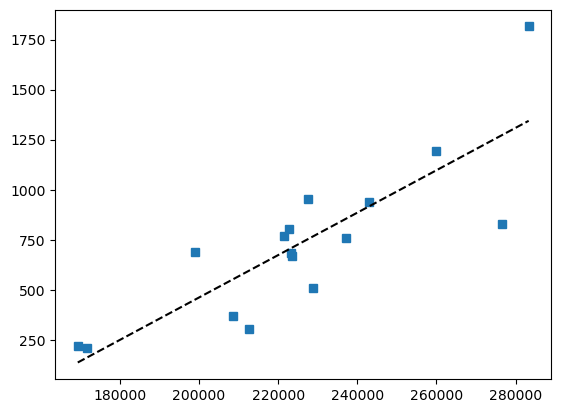

In [94]:
xvals = np.linspace(np.nanmin(yearly_sum_ml), np.nanmax(yearly_sum_ml), 100)
print(res)
fig, ax = plt.subplots()
ax.plot(yearly_sum_ml, yearly_sum , 's')
ax.plot(xvals, xvals*res.slope + res.intercept, 'k--')


#### Other plot (not needed)

C:\Users\ophme\AppData\Local\Temp\ipykernel_49588\289421508.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['June' ,'July', 'August', 'September', 'October'])


Text(0.5, 1.0, 'Daily sum of fires')

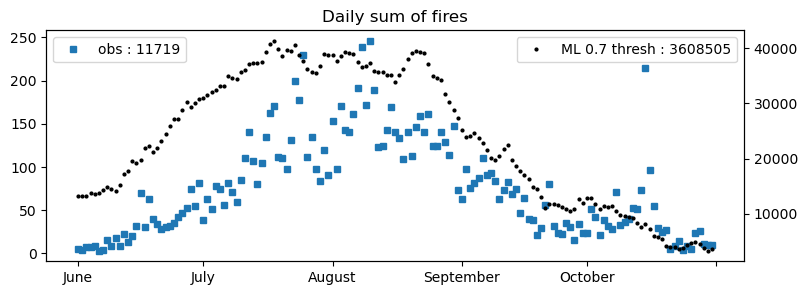

In [95]:
fig, ax = plt.subplots(figsize = (9, 3))
ax2 = ax.twinx()
ax.plot(dates_year, combined_fires, 's', label = 'obs : ' + str(int(np.nansum(combined_fires))), ms = 5, zorder = 10)
ax2.plot(dates_year, combined_fires_ml, 'o',  c = 'k', ms = 2, label = 'ML ' + str(prob) + ' thresh : ' + str(int(np.nansum(combined_fires_ml))), zorder = 1)
ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
ax.set_xticklabels(['June' ,'July', 'August', 'September', 'October'])
ax.set_title('Daily sum of fires')

### 2. Calculate daily number of fires

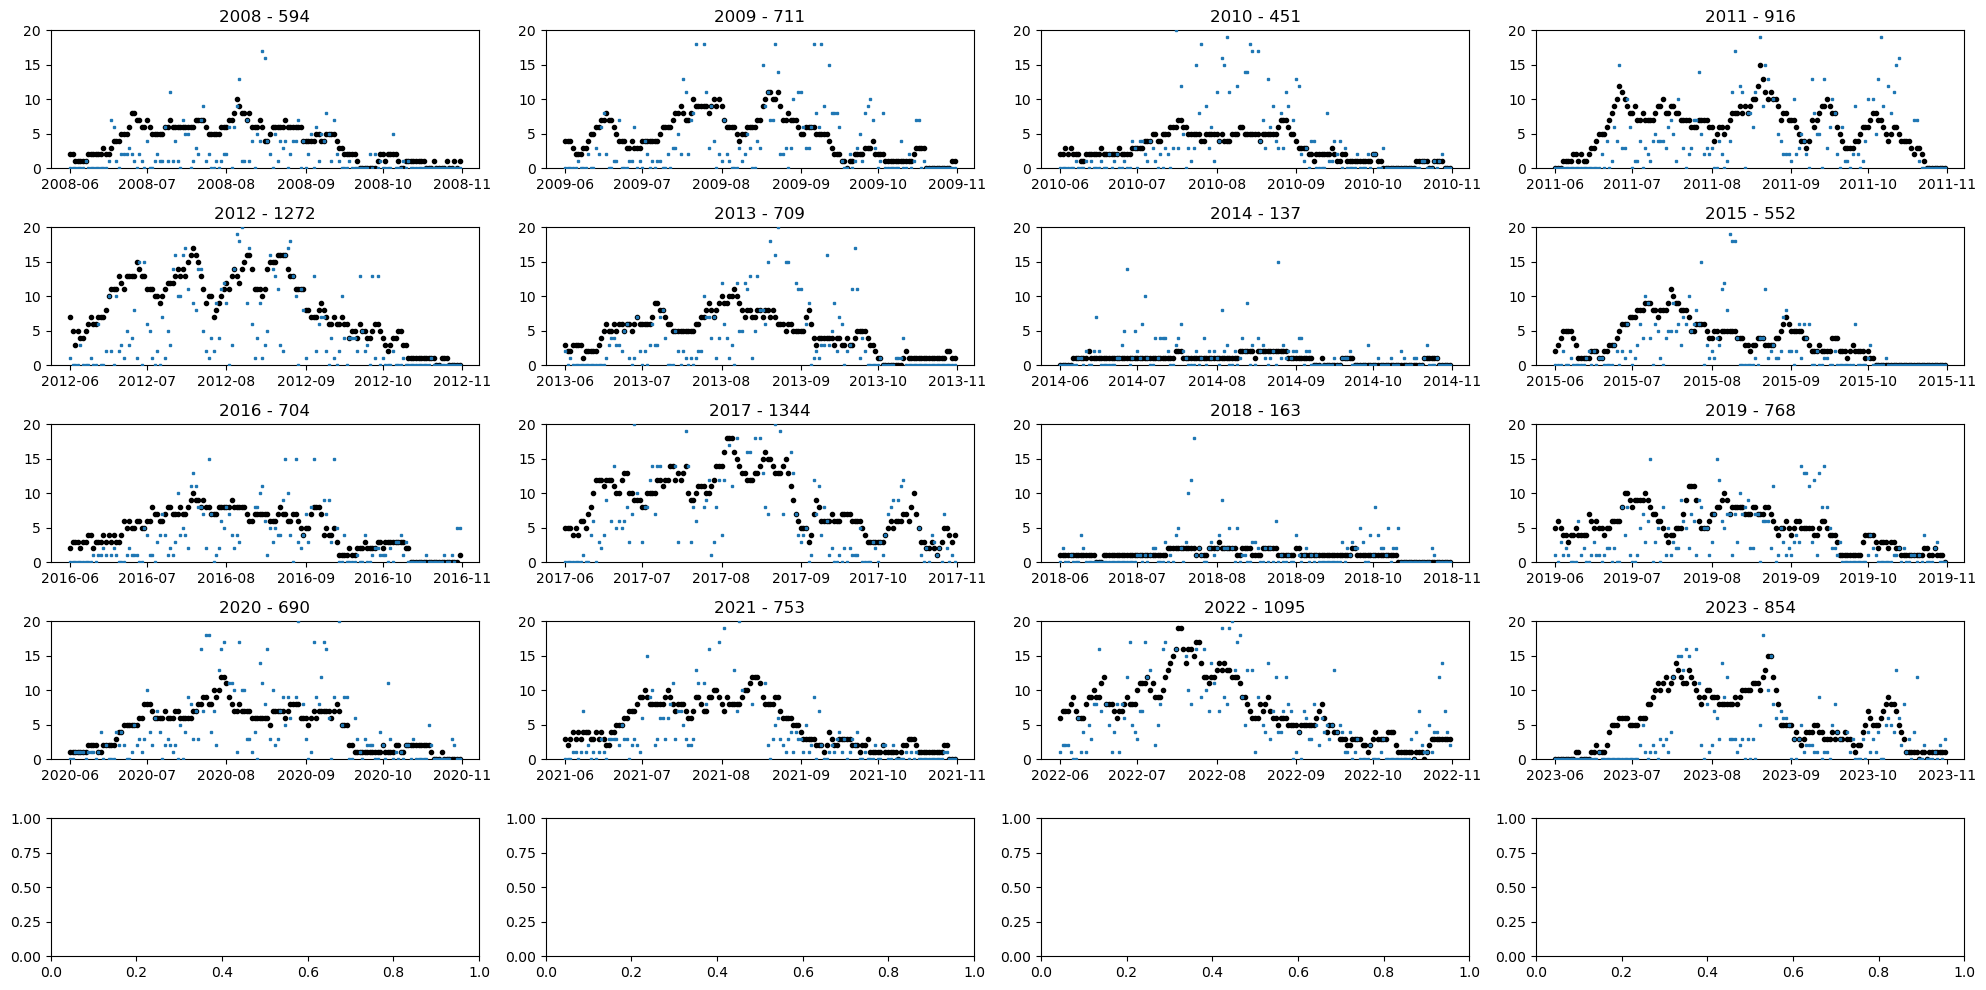

In [96]:
df_count = pd.DataFrame(index = dates)
df_count['count'] = ''
total_count_fires = []

fig, axs = plt.subplots(5, 4, figsize = (20, 10)) 
for i, year in enumerate(years):
    
    # Select only dates for a given year
    dates_year = dates[dates.year == int(year)]

    # Obtain number of expected fires from linear regression
    sum_year = yearly_sum_ml[i]*res.slope + res.intercept

    # Calculate factor 
    factor = np.nansum(combined_fires_yearly_ml[i, :])/ sum_year

    # Obtain number of fires and add to list 
    scaled_number_fires = np.round(combined_fires_yearly_ml[i, :]/factor, 0)
    total_count_fires= np.concatenate([total_count_fires, scaled_number_fires])

    # Plot
    ax = fig.axes[i]
    ax.plot(dates_year, scaled_number_fires, 'k.', label = 'ML'+ ' : ' + str(int(sum_year)))
    ax.plot(dates_year, combined_fires_yearly[i,:], 's', label = 'obs : ' + str(int(np.nansum(combined_fires_yearly[i,:]))), ms = 2, zorder = 10)
    ax.set_title(str(years[i]) + ' - ' + str(int(sum_year)))
    ax.set_ylim(0, 20)
plt.tight_layout()

In [97]:
df_count['count']= total_count_fires

(0.0, 50.0)

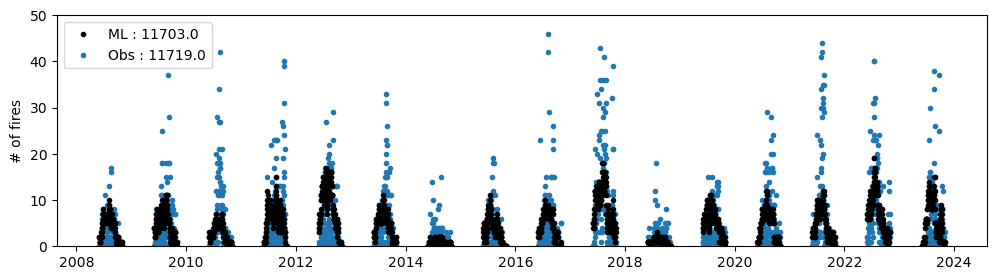

In [98]:
fig, ax = plt.subplots(figsize = (12, 3))
ax.plot(dates, df_count['count'].values, 'k.', label = 'ML : ' + str(np.nansum(df_count['count'].values)))
ax.plot(dates, combined_fires_yearly.flatten(), '.' , zorder = 0, label = 'Obs : ' + str(np.nansum(combined_fires_yearly.flatten())))
ax.legend()
ax.set_ylabel('# of fires')
ax.set_ylim(0, 50) 

In [99]:
df_count.to_csv(path + 'df_count.csv')

In [100]:
df_count = pd.read_csv(path + 'df_count.csv')

### 3. Select location for each date 

#### Select method to use 

NOTE: The same threshold is used as defined in 1.

In [101]:
select_type = 'thresh' # or dice 

In [102]:
df_probs['id'] = df_probs.index

#### For each day, sample a number of ids corresponding to the number of fires

In [103]:
df_ignition = pd.DataFrame(columns = ['date', 'id'])

i = 0
for year in years: 
    year = str(year)
    df = df_probs.filter(like= year)
    
    for column_name, item in df.items():
        
        # Random probability
        vals = np.zeros(len(item))
        random_probas = np.random.rand(len(item))

        num_fires = int(df_count['count'][i])
        if num_fires < 0:
            num_fires = 0
            
        # Use sample function to select ids based on condition
        if select_type == 'thresh':
            indices = df_probs['id'][item > prob].sample(num_fires)
        elif select_type == 'dice':
            indices = df_probs['id'][item > random_probas].sample(num_fires)

        # Create a dataframe with a row per fire 
        for ind in indices:
            df_temp = pd.DataFrame({"date":[str(column_name)[:10]], "id": [ind]})
            df_ignition = pd.concat([df_ignition, df_temp], ignore_index=True)
            
        i = i +1   
       

In [104]:
df_ignition

,date,id
0,2008-06-01,105105
1,2008-06-01,81328
2,2008-06-02,94064
3,2008-06-02,81773
4,2008-06-03,83535
...,...,...
11698,2023-10-27,98921
11699,2023-10-28,98694
11700,2023-10-29,50749
11701,2023-10-30,83091


#### Assign geometry to corresponding id

In [105]:
grid = gpd.read_file("O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder + "/grid/europe_10km_grid.shp")

In [106]:
grid = grid[['id', 'geometry']].to_crs(4326)

In [107]:
grid['id'] = grid['id'].astype('int')

In [108]:
grid = grid.set_index('id')

In [109]:
geometries = []
for i, row in df_ignition.iterrows():
    geometries.append(grid.loc[row.id, 'geometry'])

In [110]:
df_ignition['geometry'] = geometries

#### Convert to geopandas and sample point randomly within grid 

In [111]:
df_ignition_gpd = gpd.GeoDataFrame(df_ignition, geometry=df_ignition["geometry"])

In [112]:
df_ignition_gpd['sample_point'] = df_ignition_gpd.geometry.sample_points(1)

In [113]:
df_ignition['lon'] = df_ignition_gpd.sample_point.x
df_ignition['lat'] = df_ignition_gpd.sample_point.y

In [114]:
df_ignition

,date,id,geometry,lon,lat
0,2008-06-01,105105,"POLYGON ((25.260605859600926 35.2664024517794,...",25.276005,35.239932
1,2008-06-01,81328,"POLYGON ((13.53816382709535 38.0022440508001, ...",13.621003,37.931124
2,2008-06-02,94064,POLYGON ((20.387864922074694 39.68966807900267...,20.424814,39.595006
3,2008-06-02,81773,POLYGON ((13.73930903303917 37.540348849961276...,13.750091,37.485311
4,2008-06-03,83535,POLYGON ((14.624323251544569 37.31945433151522...,14.670285,37.282633
...,...,...,...,...,...
11698,2023-10-27,98921,POLYGON ((22.61937391203588 37.868119270300106...,22.640575,37.838317
11699,2023-10-28,98694,POLYGON ((22.624751437642992 38.50839813021644...,22.705223,38.435079
11700,2023-10-29,50749,POLYGON ((-2.0920013300565063 37.2045090234985...,-1.991008,37.162982
11701,2023-10-30,83091,POLYGON ((14.423832301063122 37.69265329994335...,14.457867,37.604952


#### Save list of points

In [115]:
#df_ignition = df_ignition.drop(columns = ['id', 'geometry'])

In [116]:
if save == True:
    df_ignition.drop(columns = ['id', 'geometry']).to_csv(path + 'results/ignition-selection/fire-season-ignition-points-2008-2023' + select_type + str(prob) +'.csv')

### 4. Visualise results 

#### Groupd by id and counter the number of fires per id

In [117]:
new_data = df_ignition.groupby('id').size().reset_index(name='count')
len(new_data)

3857

In [118]:
fires_csv = pd.DataFrame()
fires_csv['id'] = np.int64(fires_all.id)
fires_csv = fires_csv.groupby('id').size().reset_index(name='count')
len(fires_csv)

3525

In [119]:
fires_csv

,id,count
0,37298,2
1,37299,2
2,37517,1
3,37536,2
4,37537,1
...,...,...
3520,109928,1
3521,109929,4
3522,109930,2
3523,109931,2


In [120]:
for i, row in new_data.iterrows():
    new_data.loc[i, 'geometry'] = grid.loc[row.id, :].geometry



In [121]:
for i, row in fires_csv.iterrows():
    try:
        fires_csv.loc[i, 'geometry'] = grid.loc[row.id, :].geometry
    except Exception as e:
        print(e)
        fires_csv.loc[i, 'geometry'] = np.nan
   

43717
43718


In [122]:
fires_csv = fires_csv.dropna()

In [123]:
new_data = gpd.GeoDataFrame(new_data, geometry=new_data["geometry"]).set_crs('epsg:4326')
fires_csv = gpd.GeoDataFrame(fires_csv, geometry=fires_csv["geometry"]).set_crs('epsg:4326')

In [124]:
if save == True:
    new_data.to_file(path + 'results/ignition-selection/count_fire-season-ignition-points-2008-2023' + select_type + str(prob) +'.shp')

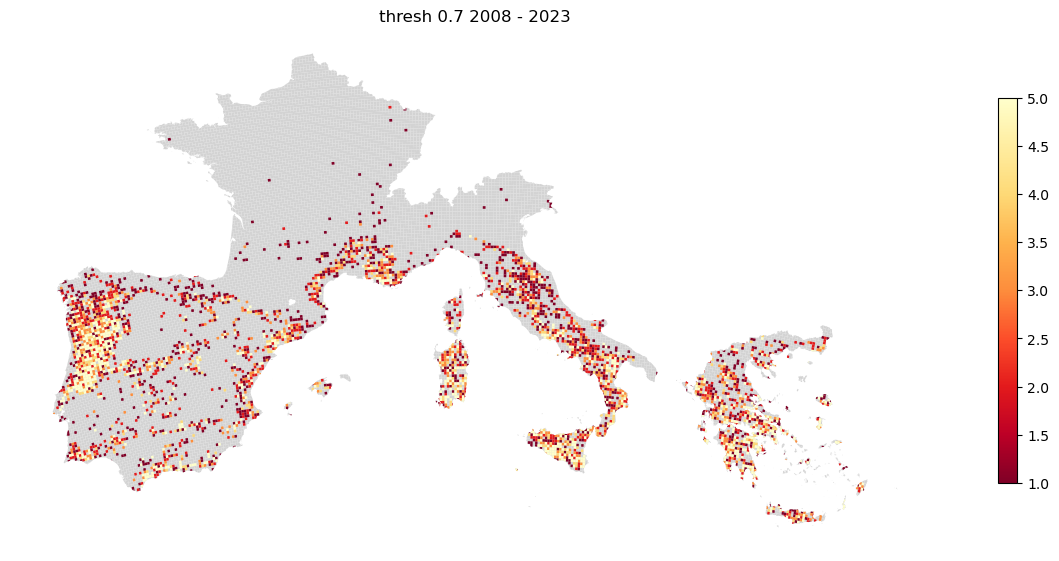

In [125]:
fig, ax = plt.subplots(figsize = (15, 10))
grid.plot(color = 'lightgrey', ax = ax, zorder = 0)
new_data.plot('count', ax = ax, cmap = 'YlOrRd_r', legend = True, vmin = 1, vmax = 5, legend_kwds={
        "shrink":.5   },)
#fires.plot(ax = ax,  color = 'k', zorder = 10)
if select_type == 'dice':
    ax.set_title(select_type, fontsize = 12)
else:
   ax.set_title(select_type + ' ' + str(prob) + ' 2008 - 2023', fontsize = 12)
#
ax.set_axis_off()

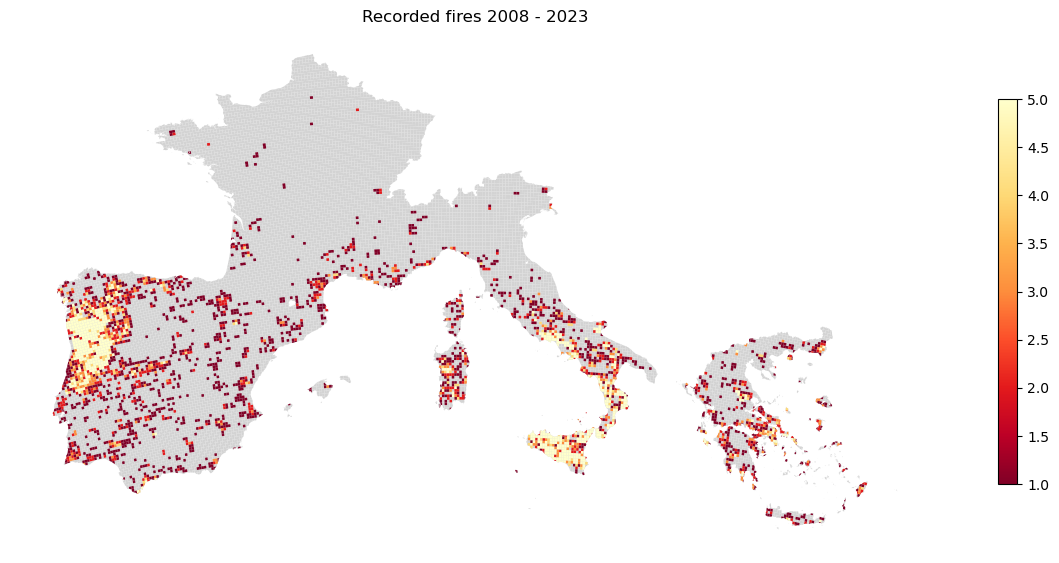

In [126]:
fig, ax = plt.subplots(figsize = (15, 10))
grid.plot(color = 'lightgrey', ax = ax, zorder = 0)
fires_csv.plot('count', ax = ax, cmap = 'YlOrRd_r', legend = True, vmin = 1, vmax = 5, legend_kwds={
        "shrink":.5   },)
ax.set_title('Recorded fires 2008 - 2023')
ax.set_axis_off()

In [127]:
if save == True:
    fires_csv.to_file(path + 'results/ignition-selection/count_recorded_fires-2008-2023.shp')

In [128]:
fires_csv

,id,count,geometry
0,37298,2,"POLYGON ((-9.47366 38.73335, -9.47411 38.75076..."
1,37299,2,"POLYGON ((-9.39232 38.70163, -9.40458 38.70318..."
2,37517,1,"POLYGON ((-9.42116 38.92937, -9.34378 38.94518..."
3,37536,2,"POLYGON ((-8.91242 37.18306, -8.91028 37.18865..."
4,37537,1,"POLYGON ((-8.91779 37.14545, -8.90919 37.15556..."
...,...,...,...
3520,109928,1,"POLYGON ((27.98794 36.34383, 28.09632 36.32263..."
3521,109929,4,"POLYGON ((27.96521 36.25566, 28.07348 36.23449..."
3522,109930,2,"POLYGON ((28.0188 36.07557, 28.00305 36.06761,..."
3523,109931,2,"POLYGON ((27.99141 36.06173, 27.98732 36.05936..."
